# Rockall Trough transport

In [1]:
%load_ext autoreload
import sys; sys.path.append(r'../') # Add this line at the beginner of each notebook to be able to load local functions 
%matplotlib inline
from matplotlib import pyplot as plt
import src.features.RT_functions as rtf
import src.features.RT_data as rtd

In [2]:
import dask
import datetime
import gsw
import scipy
import scipy.io
import cmocean as cm
import numpy as np
import pandas as pd
import seawater as sw
import scipy.signal as signal
import palettable.colorbrewer as cb
import xarray as xr
from pathlib import Path
from scipy.signal import butter, filtfilt
from xhistogram.xarray import histogram as xhist

### Set in- and output path

In [3]:
# output data
data_out_path = "C:/Users/sa07kb/Projects/Rockall_Trough_Transports/data/processed/"
Path(data_out_path).mkdir(parents=True, exist_ok=True)

In [4]:
# intput data
global_data_path = Path("C:/Users/sa07kb/OneDrive - SAMS/data/")
raw_data_path = Path('../data/raw')

# file directories
GEBCO_data_path = (global_data_path/ 'data_GEBCO')
GLORYS_data_path = (global_data_path/ 'data_GLORYS')
RT_mooring_data_path = (global_data_path/ 'data_RT_mooring')
ERA5_data_path = (global_data_path/ 'data_ERA5/Rockall_Trough')

# file names
RT_mooring_fn = 'Rockall-Trough-Mooring-Time-Series-2022.nc'
RT_mooring_loc = 'Ellet_array_mooring_location.csv'
GEBCO_fn = 'GEBCO_2014_2D_-22.0_55.0_-7.0_59.0.nc'
GLORYS_fn_re = list(sorted(
        (GLORYS_data_path).glob(f"*reanalyis-phy*Vvel.nc") # reanalysis
    ))
GLORYS_fn_an = list(sorted(
        (GLORYS_data_path).glob(f"*anfc-phy-001_024_Vvel.nc") # analysis/forecasts
    ))
ERA5_fn = 'ERA5_tauxy_RT_2014-2022.nc' 

## Parameter Preamble

In [5]:
filter_length = 90     # (days)
corr_model = 0.0759    # Correction parameter (m/s) to adjust GLORYS DAC V component to the 8 month DAC from ADCP
z_cutoff_EW = 750     # Depth (m) where transition from GLORYS-ADCP data to CM data at Eastern wedge
z_cutoff_WW = 250     # Depth (m) limit of upper-left corner cutout
lon_cutoff_WW = -12.906  # Longitude limit of upper-left corner cutout
NX_WW = 100            # Horizontal grid size in Western wedge
NX_MB = 100           # Horizontal grid size in Mid-basin (needed for Ekman calc.)
NX_EW = 100            # Horizontal grid size in Eastern wedge
SA_ref = 35.34         # Reference Absolute Salinity (g/kg), for freshwater flux calc
CT_ref = 7.07          # Reference Conservative Temperature (C), for heat flux calc
rhoCp = 4.1e6         # Constant: Reference density times specific heat capacity (J m^-3 C^-1)   
rho0 = 1027            # Reference density          
Omega = 7.2921e-5     # Earth's rotation

## Load Data and prepare for calculations

In [6]:
# Rockall Trough mooring location
moor_ds=pd.read_csv(raw_data_path/RT_mooring_loc)
moor_ds = moor_ds.set_index(['ID']).to_xarray()

lon_RTWB1 = moor_ds.sel(ID='RTWB1').lon.values
lat_RTWB1 = moor_ds.sel(ID='RTWB1').lat.values
lon_RTWB2 = moor_ds.sel(ID='RTWB2').lon.values
lat_RTWB2 = moor_ds.sel(ID='RTWB2').lat.values
lon_RTWB = (lon_RTWB1 + lon_RTWB2)/2
lat_RTWB = (lat_RTWB1 + lat_RTWB2)/2
lon_RTEB = moor_ds.sel(ID='RTEB1').lon.values
lat_RTEB = moor_ds.sel(ID='RTEB1').lat.values
lon_RTADCP = moor_ds.sel(ID='RTADCP').lon.values
lat_RTADCP = moor_ds.sel(ID='RTADCP').lat.values
lon_RTWS = moor_ds.sel(ID='RTWS').lon.values
lat_RTWS = lat_RTWB
lon_RTES = moor_ds.sel(ID='RTES').lon.values
lat_RTES = lat_RTEB

# gridded Rockall Trough mooring data
ds_RT = xr.open_dataset((RT_mooring_data_path/RT_mooring_fn))
ds_RT = ds_RT.where(ds_RT.TG_EAST.isel(PRES=0).notnull().drop_vars('PRES'),drop=True)

# Get z from P
ds_RT.coords['depth'] = gsw.z_from_p(ds_RT.PRES,np.mean([lat_RTWB, lat_RTEB]))
# Create merged WB1/2 CM
ds_RT['v_RTWB'] = ds_RT.V_WEST_2.where(ds_RT.V_WEST_1.isnull())
ds_RT['v_mask'] = (ds_RT.v_RTWB.notnull()+ds_RT.V_WEST_1.notnull())
ds_RT['v_RTWB'] = (ds_RT.v_RTWB.fillna(0)+ds_RT.V_WEST_1.fillna(0)).where(ds_RT.v_mask==1)

# Load  GEBCO bathymetry
ds_GEBCO = xr.open_dataset((GEBCO_data_path/GEBCO_fn))
ds_GEBCO = ds_GEBCO.where(ds_GEBCO.elevation<=0)

# load GLORYS model data
ds_GLORYS_re = xr.open_mfdataset(GLORYS_fn_re)
ds_GLORYS_an = xr.open_mfdataset(GLORYS_fn_an)
ds_GLORYS_an.coords['latitude'] = ds_GLORYS_re.latitude # lat and lon slightly different values, i.e. manually merge
ds_GLORYS_an.coords['longitude'] = ds_GLORYS_re.longitude
ds_GLORYS_an.coords['depth'] = ds_GLORYS_re.depth
ds_GLORYS = xr.concat([ds_GLORYS_re,ds_GLORYS_an],'time')

# load ERA5
ds_ERA5 = xr.open_dataset((ERA5_data_path/ERA5_fn))
ds_ERA5 = ds_ERA5.sel(expver=1).combine_first(ds_ERA5.sel(expver=5))

In [7]:
## Correct upper layer interpolation
# mask out flawed upper values - EAST
mask_hydro1 = ds_RT.SG_EAST.where(((ds_RT.PRES<=60) & 
                     (ds_RT.TIME.sel(TIME='2018-07-4,12:00:00')<=ds_RT.TIME)&
                     (ds_RT.TIME<=ds_RT.TIME.sel(TIME='2020-10-15 12:00:00')))
                   ).isnull()

mask_hydro2 = ds_RT.SG_EAST.where(((ds_RT.PRES<=80) & 
                     (ds_RT.TIME.sel(TIME='2016-6-30 12:00:00')<=ds_RT.TIME)&
                     (ds_RT.TIME<=ds_RT.TIME.sel(TIME='2016-12-10 12:00:00')))
                   ).isnull()

mask_hydro = ((mask_hydro1*1+mask_hydro2*1)==2)
TG_EAST = ds_RT.TG_EAST.where(mask_hydro).compute()
SG_EAST = ds_RT.SG_EAST.where(mask_hydro).compute()


# extrapolate values and mask out extrapolation at bottom
SG_EAST = SG_EAST.interpolate_na(dim="PRES", method="nearest", fill_value="extrapolate")
SG_EAST = SG_EAST.where(ds_RT.SG_EAST.notnull())

TG_EAST = TG_EAST.interpolate_na(dim="PRES", method="nearest", fill_value="extrapolate")
TG_EAST = TG_EAST.where(ds_RT.TG_EAST.notnull())

# mask out flawed upper values - WEST
mask_hydroW = ds_RT.SG_WEST.where(((ds_RT.PRES<=60) & 
                     (ds_RT.TIME.sel(TIME='2018-02-21 00:00')<=ds_RT.TIME)&
                     (ds_RT.TIME<=ds_RT.TIME.sel(TIME='2020-08-26 12:00:00')))
                   ).isnull()

TG_WEST = ds_RT.TG_WEST.where(mask_hydroW).compute()
SG_WEST = ds_RT.SG_WEST.where(mask_hydroW).compute()

# extrapolate values and mask out extrapolation at bottom
SG_WEST = SG_WEST.interpolate_na(dim="PRES", method="nearest", fill_value="extrapolate")
SG_WEST = SG_WEST.where(ds_RT.SG_WEST.notnull())
TG_WEST = TG_WEST.interpolate_na(dim="PRES", method="nearest", fill_value="extrapolate")
TG_WEST = TG_WEST.where(ds_RT.TG_WEST.notnull())

# overwrite files
ds_RT['SG_EAST'] = SG_EAST
ds_RT['SG_WEST'] = SG_WEST
ds_RT['TG_WEST'] = TG_WEST
ds_RT['TG_EAST'] = TG_EAST

In [8]:
ds_RT = rtf.ds_rt_swap_vert_dim(ds_RT)

# Calculations

## Horizontal and vertical grid parameters

In [9]:
# def create_grid(x_w,x_e,NX,dim)

lon_WW = xr.DataArray(np.linspace(lon_RTWS,lon_RTWB,NX_WW),dims='lon_WW')
lon_MB = xr.DataArray(np.linspace(lon_RTWB,lon_RTEB,NX_MB),dims='lon_MB')
lon_EW = xr.DataArray(np.linspace(lon_RTEB,lon_RTES,NX_EW),dims='lon_EW')
lat_WW = xr.DataArray(np.linspace(lat_RTWS,lat_RTWB,NX_WW),dims='lon_WW')
lat_MB = xr.DataArray(np.linspace(lat_RTWB,lat_RTEB,NX_MB),dims='lon_MB')
lat_EW = xr.DataArray(np.linspace(lat_RTEB,lat_RTES,NX_EW),dims='lon_EW')

lon_WW.coords['lon_WW']=lon_WW.values
lat_WW.coords['lon_WW']=lon_WW.values

lon_MB.coords['lon_MB']=lon_MB.values
lat_MB.coords['lon_MB']=lon_MB.values

lon_EW.coords['lon_EW']=lon_EW.values
lat_EW.coords['lon_EW']=lon_EW.values

In [10]:
#Get dx
dx_EW = rtf.get_dx(lon_EW,lat_EW,dim='lon_EW')
dx_MB = xr.apply_ufunc(
            gsw.distance,
            lon_MB,lat_MB,
            input_core_dims=[['lon_MB'],['lon_MB']],
            output_core_dims=[['lon_MB']],
            exclude_dims=set(('lon_MB',)), 
    )
dx_WW = rtf.get_dx(lon_WW,lat_WW,dim='lon_WW')

In [11]:
# Get x
x_WW = np.linspace(0,(NX_WW-1)*dx_WW,NX_WW).squeeze()
x_MB = np.linspace(0,(NX_MB-1)*dx_MB,NX_MB-1).squeeze()
x_EW = np.linspace(0,(NX_EW-1)*dx_EW,NX_EW).squeeze()

In [12]:
# Get dz (top/bottom cells are ~10m thick, cells are ~20m thick elsewhere)
dz = rtf.get_dz(ds_RT.depth)
ds_RT['dz']=xr.DataArray(dz,dims='depth')

In [13]:
# Get section bathymetry
bathy_WW = ds_GEBCO.elevation.interp(lon=lon_WW, lat=lat_WW).drop(['lon','lat'])
bathy_WW.coords['lon_WW']=lon_WW
bathy_EW = ds_GEBCO.elevation.interp(lon=lon_EW, lat=lat_EW).drop(['lon','lat'])
bathy_EW.coords['lon_EW']=lon_EW

## Midbasin transport based on no motion at 1760 dbar

In [14]:
# Get Coriolis freq
f = gsw.f(np.mean([lat_RTWB,lat_RTEB]))

# Get reference pressure
P_ref = ds_RT.where((ds_RT.SG_WEST+ds_RT.SG_EAST).notnull(),drop=True).PRES.max().values

# # Calculate baroclinic streamfunction
SF_RTWB = rtf.gsw_geo_strf_dyn_height(ds_RT.SG_WEST,ds_RT.TG_WEST,ds_RT.PRES,P_ref)
SF_RTEB = rtf.gsw_geo_strf_dyn_height(ds_RT.SG_EAST,ds_RT.TG_EAST,ds_RT.PRES,P_ref)

# Calculate geostrophic transport (Sv) in each cell as function of (z,t)
q_MB = ds_RT.dz*((SF_RTEB - SF_RTWB)/f)
q_MB.coords['lat_MB']=np.mean([lat_RTWB,lat_RTEB])
q_MB.coords['lon_MB']=np.mean([lon_RTWB,lon_RTEB])

# Perform vertical integral for timeseries (Sv)
Q_MB = q_MB.sum(['depth'],min_count=1)/1e6

Q_MB.attrs['name']= 'RT_Q_MB'
Q_MB.attrs['long_name']= 'RT MB Volume Transport'
Q_MB.attrs['units']='Sv'
Q_MB.attrs['Description']='Mid basin volume transport in Rockall Trough'\
' derived from dynamic height difference between the moorings RTEB1 and RTWB1+2'

## Some sensitivity analysis - extra

# Calculate temporal mean over entire timeseries and broadcast over TIME dimension
(ds_RT_ave,_) = xr.broadcast(ds_RT.mean('TIME'),ds_RT.TIME)

# % Do it again isolating CT changes/ keeping SA fixed
SF_RTWB_SAfix = rtf.gsw_geo_strf_dyn_height(ds_RT.SG_WEST,ds_RT_ave.TG_WEST,ds_RT.PRES,P_ref)
SF_RTEB_SAfix = rtf.gsw_geo_strf_dyn_height(ds_RT.SG_EAST,ds_RT_ave.TG_EAST,ds_RT.PRES,P_ref)
q_MB_SAfix = ds_RT.dz*((SF_RTEB_SAfix - SF_RTWB_SAfix)/f)
Q_MB_SAfix = q_MB_SAfix.sum('depth',min_count=1)/1e6
Q_MB_SAfix.attrs['name']= 'RT_Q_MB_SAfix'
Q_MB_SAfix.attrs['long_name']= 'RT MB Volume Transport CT fixed'
Q_MB_SAfix.attrs['units']='Sv'
Q_MB_SAfix.attrs['Description']='As Q_MB but holding temperature fixed at temporal mean at all moorings'

# % Do it again isolating SA changes / keeping CT fixed
SF_RTWB_CTfix = rtf.gsw_geo_strf_dyn_height(ds_RT_ave.SG_WEST,ds_RT.TG_WEST,ds_RT.PRES,P_ref)
SF_RTEB_CTfix = rtf.gsw_geo_strf_dyn_height(ds_RT_ave.SG_EAST,ds_RT.TG_EAST,ds_RT.PRES,P_ref)
q_MB_CTfix = ds_RT.dz*((SF_RTEB_CTfix - SF_RTWB_CTfix)/f)
Q_MB_CTfix = q_MB_CTfix.sum('depth',min_count=1)/1e6
Q_MB_CTfix.attrs['name']= 'RT_Q_MB_CTfix'
Q_MB_CTfix.attrs['long_name']= 'RT MB Volume Transport SA fixed'
Q_MB_CTfix.attrs['units']='Sv'
Q_MB_CTfix.attrs['Description']= 'As Q_MB but holding salinity fixed at temporal mean at all moorings'

# % Do it again holding both fixed
SF_RTWB_SAfix_CTfix = rtf.gsw_geo_strf_dyn_height(ds_RT_ave.SG_WEST,ds_RT_ave.TG_WEST,ds_RT.PRES,P_ref)
SF_RTEB_SAfix_CTfix = rtf.gsw_geo_strf_dyn_height(ds_RT_ave.SG_EAST,ds_RT_ave.TG_EAST,ds_RT.PRES,P_ref)
q_MB_SAfix_CTfix = ds_RT.dz*((SF_RTEB_SAfix_CTfix - SF_RTWB_SAfix_CTfix)/f)
Q_MB_SAfix_CTfix = q_MB_SAfix_CTfix.sum('depth',min_count=1)/1e6
Q_MB_SAfix_CTfix.attrs['name']= 'RT_Q_MB_SAfix_CTfix'
Q_MB_SAfix_CTfix.attrs['long_name']= 'RT MB Volume Transport SA and CT fixed'
Q_MB_SAfix_CTfix.attrs['units']='Sv'
Q_MB_SAfix_CTfix.attrs['Description']= 'As Q_MB but holding temperature and salinity fixed at temporal mean at all moorings'

# % Do it again isolating CT_RTWB
q_MB_WB_CTvar = ds_RT.dz*((SF_RTEB_SAfix_CTfix - SF_RTWB_SAfix)/f)
Q_MB_WB_CTvar = q_MB_WB_CTvar.sum('depth',min_count=1)/1e6
Q_MB_WB_CTvar.attrs['name']= 'RT_Q_MB_WB_CTvar'
Q_MB_WB_CTvar.attrs['long_name']= 'RT MB Volume Transport isolating CT changes at RTWB'
Q_MB_WB_CTvar.attrs['units']='Sv'
Q_MB_WB_CTvar.attrs['Description']= 'As Q_MB but isolating temperature changes at RTWB'\
                        ' and holding temperature at RTEB and salinity at RTWB & RTEB'\
                        ' fixed at temporal mean'

# % Do it again isolating CT_RTEB
q_MB_EB_CTvar = ds_RT.dz*((SF_RTEB_SAfix - SF_RTWB_SAfix_CTfix)/f)
Q_MB_EB_CTvar = q_MB_EB_CTvar.sum('depth',min_count=1)/1e6
Q_MB_EB_CTvar.attrs['name']= 'RT_Q_MB_EB_CTvar'
Q_MB_EB_CTvar.attrs['long_name']= 'RT MB Volume Transport isolating CT changes at RTEB'
Q_MB_EB_CTvar.attrs['units']='Sv'
Q_MB_EB_CTvar.attrs['Description']= 'As Q_MB but isolating temperature changes at RTEB'\
                    ' and holding temperature at RTWB and salinity at RTWB & RTEB'\
                    ' fixed at temporal mean'

# Merge to dataset
RT_Q_MB = xr.merge([Q_MB.rename(Q_MB.attrs['name']),
                Q_MB_SAfix.rename(Q_MB_SAfix.attrs['name']),
                Q_MB_CTfix.rename(Q_MB_CTfix.attrs['name']),
                Q_MB_SAfix_CTfix.rename(Q_MB_SAfix_CTfix.attrs['name']),
                Q_MB_WB_CTvar.rename(Q_MB_WB_CTvar.attrs['name']),
                Q_MB_EB_CTvar.rename(Q_MB_EB_CTvar.attrs['name'])])

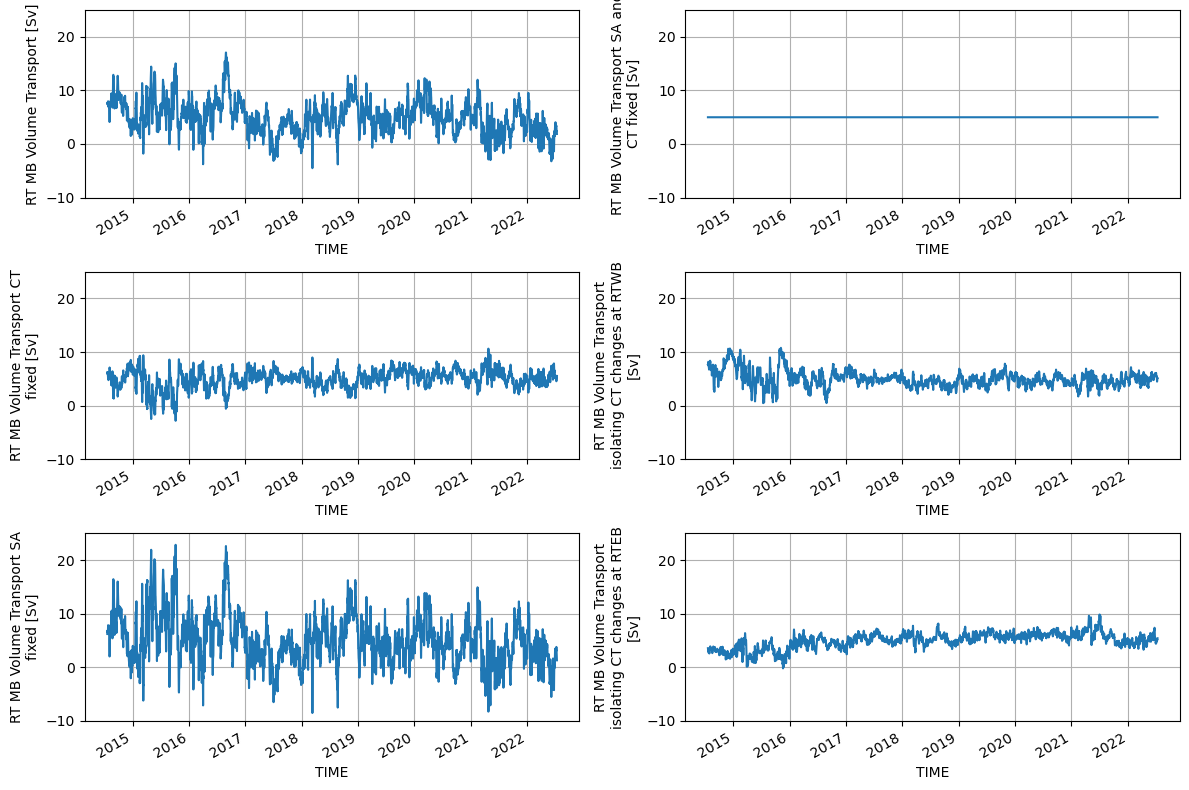

In [15]:
fig,axs=plt.subplots(3,2,figsize=[12,8])
ax = axs[0,0]
RT_Q_MB.RT_Q_MB.plot(ax=ax)
ax = axs[1,0]
RT_Q_MB.RT_Q_MB_SAfix.plot(ax=ax)
ax = axs[2,0]
RT_Q_MB.RT_Q_MB_CTfix.plot(ax=ax)
ax = axs[0,1]
RT_Q_MB.RT_Q_MB_SAfix_CTfix.plot(ax=ax)
ax = axs[1,1]
RT_Q_MB.RT_Q_MB_WB_CTvar.plot(ax=ax)
ax = axs[2,1]
RT_Q_MB.RT_Q_MB_EB_CTvar.plot(ax=ax)
for ax in axs.flat:
    ax.grid()
    ax.set_ylim([-10,25])
    ax.set_title('')
fig.tight_layout()

In [16]:
# # create MB matrix, fine horizontal grid, new and not in Fraser et al. (2022)
SG_MB_grid = xr.concat([ds_RT.SG_WEST.expand_dims('lon_MB'),
          ds_RT.SG_EAST.expand_dims('lon_MB')],dim='lon_MB')
SG_MB_grid['lon_MB']=[lon_RTWB,lon_RTEB]
SG_MB_grid.coords['lat_MB']= ('lon_MB',[lat_RTWB,lat_RTEB])

TG_MB_grid = xr.concat([ds_RT.TG_WEST.expand_dims('lon_MB'),
          ds_RT.TG_EAST.expand_dims('lon_MB')],dim='lon_MB')
TG_MB_grid['lon_MB']=[lon_RTWB,lon_RTEB]
TG_MB_grid.coords['lat_MB']= ('lon_MB',[lat_RTWB,lat_RTEB])

SG_MB_grid = SG_MB_grid.interp(lon_MB=lon_MB)
TG_MB_grid = TG_MB_grid.interp(lon_MB=lon_MB)

# Calculate baroclinic streamfunction
SF_MB_grid = xr.apply_ufunc(
        gsw.geo_strf_dyn_height,
        SG_MB_grid,TG_MB_grid,TG_MB_grid.PRES,P_ref,
        kwargs={'axis':2},
        input_core_dims=[['lon_MB', 'TIME', 'depth'],['lon_MB', 'TIME', 'depth'],['depth'],[]],
        output_core_dims=[['lon_MB', 'TIME', 'depth']],
        dask = 'parallelized')

# Calculate geostrophic transport (Sv) in each cell as function of (z,t)
q_MB_grid = dz*(SF_MB_grid.diff('lon_MB')/f)
lon_MB = xr.DataArray(((SF_MB_grid.lon_MB[:-1].values+SF_MB_grid.lon_MB[1:].values)/2),dims='lon_MB')
q_MB_grid['lon_MB']=lon_MB
lat_MB = xr.DataArray(((SF_MB_grid.lat_MB[:-1].values+SF_MB_grid.lat_MB[1:].values)/2),dims='lon_MB')
q_MB_grid.coords['lat_MB']= lat_MB
q_MB_grid['dx_MB'] = dx_MB

ds_RT_MB_grid = xr.merge([q_MB_grid.rename('q'),
                      TG_MB_grid.rename('CT').drop('lat_MB').interp(lon_MB=q_MB_grid.lon_MB),
                      SG_MB_grid.rename('SA').drop('lat_MB').interp(lon_MB=q_MB_grid.lon_MB)])

## Western wedge transport

In [17]:
# Constant value east of WB1
v_WW = ds_RT.v_RTWB.rename('v_WW').compute()
(v_WW,_) = xr.broadcast(v_WW,xr.DataArray(lon_WW, dims="lon_WW"))
v_WW.coords['lon_WW']=lon_WW
v_WW.coords['lat_WW']=lat_WW
v_WW = v_WW.where(lon_WW>=lon_RTWB1)

# Upper 250 m: Linear decay from WB1 value to 0, western limit is cut off lon
i_bathy = (lon_WW<lon_RTWB1) & (lon_WW>=lon_cutoff_WW)
y = xr.apply_ufunc(
    np.linspace,
    0,ds_RT.v_RTWB.where((ds_RT.depth<z_cutoff_WW)),sum(i_bathy),
    input_core_dims=[[],['depth','TIME'],[]],
    output_core_dims=[['lon_WW','depth','TIME']],
    dask='parallelized')

y.coords['lon_WW']= lon_WW[(lon_WW<lon_RTWB1) & (lon_WW>=lon_cutoff_WW)]

(v_WW,y)=xr.broadcast(v_WW,y)
mask = (v_WW.notnull()+y.notnull())
v_WW = (v_WW.fillna(0)+y.fillna(0)).where(mask)

# Below 250 m: Linear decay from WB1 value to 0, western limit is bathymetry
i_bathy =(-1*bathy_WW.where(lon_WW<lon_RTWB1)>ds_RT.depth.where(ds_RT.depth>z_cutoff_WW))

for idx,bathy in enumerate(i_bathy.sum('lon_WW')):
    if bathy>0:
        y1 = xr.apply_ufunc(
        np.linspace,
        0,ds_RT.v_RTWB.isel(depth=[idx]),bathy,
        input_core_dims=[[],['TIME','depth'],[]],
        output_core_dims=[['lon_WW','TIME','depth']], 
        dask='parallelized')
        
        y1.coords['lon_WW']= lon_WW.values[i_bathy[:,idx]]
        (_,y1)=xr.broadcast(v_WW,y1)
        mask = (v_WW.notnull()+y1.notnull())
        v_WW = (v_WW.fillna(0)+y1.fillna(0)).where(mask)
v_WW = v_WW.fillna(0).where(v_WW.depth<-1*bathy_WW)

# Transport in each cell
q_WW = dx_WW*ds_RT.dz*(v_WW/1e2)

# Integrate for transport timeseries (Sv)
Q_WW = q_WW.sum(['depth','lon_WW'],min_count=1)/1e6 
Q_WW.coords['mask_WW'] = ds_RT.v_RTWB.isel(depth=50).notnull()
Q_WW.attrs['name']= 'RT_Q_WW'
Q_WW.attrs['long_name']= 'RT WW Volume Transport'
Q_WW.attrs['units']='Sv'
Q_WW.attrs['Description']='Volume transport at western wedge of Rockall Trough'\
' derived from moored velocity measurements at RTWB1+2'

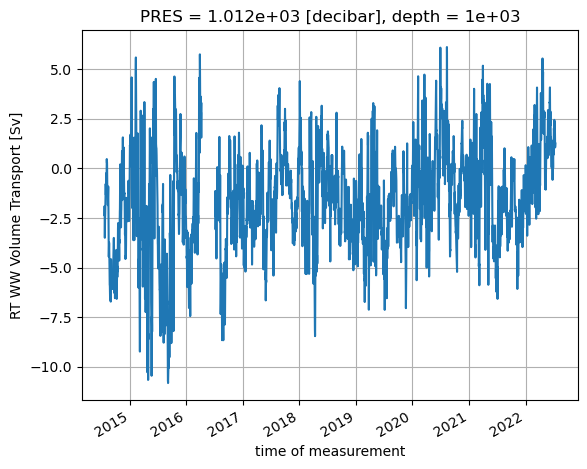

In [18]:
Q_WW.where(Q_WW.mask_WW).plot()
plt.grid()

## Eastern wedge

In [19]:
v_GLO_RTADCP = ds_GLORYS.vo.interp(longitude=lon_RTADCP,
                    latitude=lat_RTADCP,
                    time=('TIME',ds_RT.TIME.data),
                    depth=('depth',ds_RT.depth.data)) + corr_model

# Duplicate top and bottom GLORYS-ADCP values
v_GLO_RTADCP = v_GLO_RTADCP.interpolate_na(dim="depth", method="nearest", fill_value="extrapolate")

# create velocity matrix with mooring velocity at western border
(v_EW,_) = xr.broadcast(ds_RT.V_EAST/100,xr.DataArray(lon_EW, dims="lon_EW"))
v_EW.coords['lon_EW'] = lon_EW
v_EW0 = v_EW.where((ds_RT.depth<z_cutoff_EW)).where(lon_EW==lon_EW[-1])*0
v_EW1 = v_EW.where((ds_RT.depth>z_cutoff_EW))
v_EW = v_EW.where((ds_RT.depth<z_cutoff_EW)).where(lon_EW<lon_EW[1])

# combine both
mask = (v_EW.notnull()+v_EW1.notnull()+v_EW0.notnull())
v_EW = (v_EW.fillna(0)+v_EW1.fillna(0)+v_EW0.fillna(0)).where(mask)


# create velocity matrix with GLORYS-ADCP closest to the position of RTADCP
(v_EW2,_) = xr.broadcast(v_GLO_RTADCP,xr.DataArray(lon_EW, dims="lon_EW"))
v_EW2.coords['lon_EW'] = lon_EW
v_EW2.coords['lat_EW'] = lat_EW
v_EW3 = v_EW2
v_EW2 = v_EW2.where((ds_RT.depth<z_cutoff_EW)
                   ).where(lon_EW==v_EW2.lon_EW.sel(lon_EW=lon_RTADCP,method='nearest').values)

# ############################ to be commented if matlab-style (not correct) is wanted - see below
# # Python version (correct version)
mask = (v_EW.notnull()+v_EW2.notnull())
v_EW = (v_EW.fillna(0)+v_EW2.fillna(0)).where(mask)

# ########################### matlab style - to be uncommented if original ouput is wanted (Fraser et al., 2022)
# # In the matlab script the GLORY ADCP data was duplicated to the lon east of the ADCP before interpolating to zero. This causes a deviation of ~0.01cm/s
# # To include the original matlab-style interpolation the following code need to replace the two lines above
# ###########################
# # v_EW3 = v_EW3.where((ds_RT.depth>z_cutoff_EW)
# #                    ).where(lon_EW==v_EW2.lon_EW.sel(lon_EW=-9.331,method='nearest').values)

# # # combine both
# # mask = (v_EW.notnull()+v_EW2.notnull()+v_EW3.notnull())
# # v_EW = (v_EW.fillna(0)+v_EW2.fillna(0)+v_EW3.fillna(0)).where(mask)
# ############################

# Linear interpolation from mooring velocity to GLORYS-ADCP in depth shallower than 750m 
v_EW = v_EW.interpolate_na(dim="lon_EW", method="linear")

# Mask bathy
v_EW = v_EW.where(v_EW.depth<-1*bathy_EW)

# Transport in each cell
q_EW = dx_EW*ds_RT.dz*(v_EW)

# Integrate for transport timeseries (Sv)
Q_EW = q_EW.sum(['depth','lon_EW'],min_count=1)/1e6
Q_EW.coords['mask_EW'] = ds_RT.V_WEST_1.isel(depth=50).notnull()
Q_EW.attrs['name']= 'RT_Q_EW'
Q_EW.attrs['long_name']= 'RT EW Volume Transport'
Q_EW.attrs['units']='Sv'
Q_EW.attrs['Description']='Volume transport at eastern wedge of Rockall Trough'\
' derived from moored velocity measurements at RTEB1'

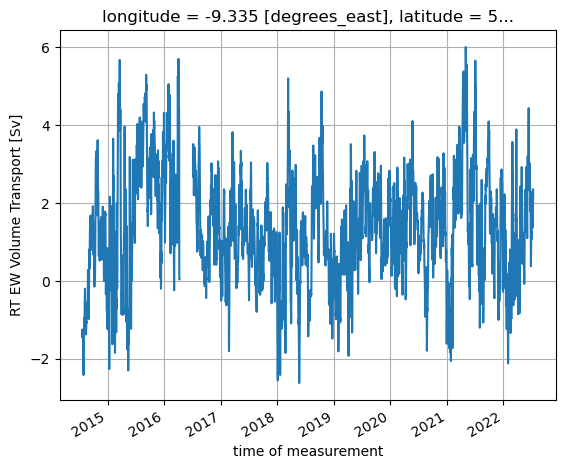

In [20]:
Q_EW.where(Q_EW.mask_EW).plot()
plt.grid()

## Ekman transport

In [33]:
ds_ERA_MB = ds_ERA5[['metss','mntss']].interp(longitude=lon_MB, latitude=lat_MB).drop(['longitude','latitude'])
ds_ERA_MB.coords['lon_MB']=lon_MB
ds_ERA_WW = ds_ERA5[['metss','mntss']].interp(longitude=lon_WW, latitude=lat_WW).drop(['longitude','latitude'])
ds_ERA_WW.coords['lon_WW']=lon_WW
ds_ERA_EW = ds_ERA5[['metss','mntss']].interp(longitude=lon_EW, latitude= lat_EW).drop(['longitude','latitude'])
ds_ERA_EW.coords['lon_EW']=lon_EW

# Get normal and tangent to each section
def tau_rot(ds,lat,lon):
    (_,pa) = np.radians(sw.dist(lat[:2],lon[:2],'km'))
    tau_rot = np.cos(pa)*ds.metss + np.sin(pa)*ds.mntss
    return tau_rot

# Get tau tangent to section
tau_para_MB = tau_rot(ds_ERA_MB,lat_MB,lon_MB)
tau_para_WW = tau_rot(ds_ERA_WW,lat_WW,lon_WW)
tau_para_EW = tau_rot(ds_ERA_EW,lat_EW,lon_EW)

# Get Ekman
f = 2*Omega*np.sin(np.radians(lat_RTWB))
V_Ek_WW = -1*tau_para_WW/(f*rho0)
V_Ek_MB = -1*tau_para_MB/(f*rho0)
V_Ek_EW = -1*tau_para_EW/(f*rho0)

# Transport per cell in Sv
q_Ek_WW = V_Ek_WW*dx_WW/1e6
q_Ek_MB = V_Ek_MB*dx_MB/1e6
q_Ek_EW = V_Ek_EW*dx_EW/1e6

# Integrate transport timeseries
Q_Ek_WW = q_Ek_WW.sum('lon_WW')
Q_Ek_WW.attrs['name']= 'Q_Ek_WW'
Q_Ek_WW.attrs['long_name']= 'RT WW Ekman Transport'
Q_Ek_WW.attrs['units']='Sv'
Q_Ek_WW.attrs['Description']= 'Ekman Transport at wester wedge of Rockall Trough'\
' derived from ERA5 monthly data'

Q_Ek_MB = q_Ek_MB.sum('lon_MB')
Q_Ek_MB.attrs['name']= 'Q_Ek_MB'
Q_Ek_MB.attrs['long_name']= 'RT MB Ekman Transport'
Q_Ek_MB.attrs['units']='Sv'
Q_Ek_MB.attrs['Description']= 'Ekman Transport across Rockall Trough'\
' derived from ERA5 monthly data'

Q_Ek_EW = q_Ek_EW.sum('lon_EW')
Q_Ek_EW.attrs['name']= 'Q_Ek_EW'
Q_Ek_EW.attrs['long_name']= 'RT EW Ekman Transport'
Q_Ek_EW.attrs['units']='Sv'
Q_Ek_EW.attrs['Description']= 'Ekman Transport at eastern wedge of Rockall Trough'\
' derived from ERA5 monthly data'

# Merge to dataset
RT_Q_Ek = xr.merge([Q_Ek_WW.rename(Q_Ek_WW.attrs['name']),
                Q_Ek_MB.rename(Q_Ek_MB.attrs['name']),
                Q_Ek_EW.rename(Q_Ek_EW.attrs['name'])])

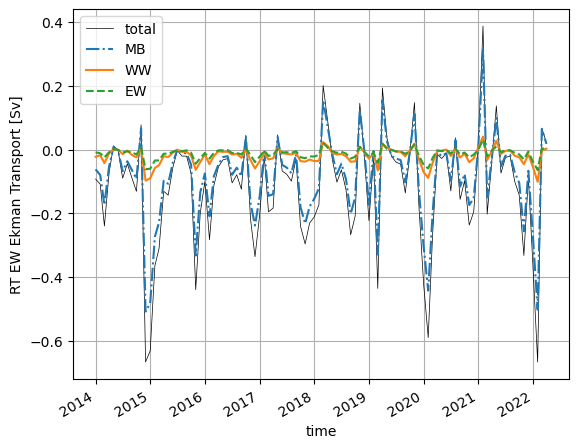

In [34]:
(RT_Q_Ek.Q_Ek_WW+RT_Q_Ek.Q_Ek_MB+RT_Q_Ek.Q_Ek_EW).plot(lw=.5,color='k',label='total')
RT_Q_Ek.Q_Ek_MB.plot.line(ls='-.',label='MB')
RT_Q_Ek.Q_Ek_WW.plot.line(ls='-',label='WW')
RT_Q_Ek.Q_Ek_EW.plot.line(ls='--',label='EW')
plt.grid()
plt.legend()

## Heat and Freshwater Fluxes

In [35]:
# Get SA and CT fields - interpolate for midbasin
ds_RT['SG_MB'] = (ds_RT.SG_WEST + ds_RT.SG_EAST)/2
ds_RT['TG_MB'] = (ds_RT.TG_WEST + ds_RT.TG_EAST)/2

# Compute fluxes in each cell
qh_EW = rhoCp*q_EW*(ds_RT.TG_EAST - CT_ref)
qh_MB = rhoCp*q_MB*(ds_RT.TG_MB - CT_ref)
qh_WW = rhoCp*q_WW*(ds_RT.TG_WEST - CT_ref)
qf_EW = -1*q_EW*(ds_RT.SG_EAST - SA_ref)/SA_ref
qf_MB = -1*q_MB*(ds_RT.SG_MB - SA_ref)/SA_ref;
qf_WW = -1*q_WW*(ds_RT.SG_WEST - SA_ref)/SA_ref
qS_EW = q_EW*ds_RT.SG_EAST/1027.4
qS_MB = q_MB*ds_RT.SG_MB/1027.4;
qS_WW = q_WW*ds_RT.SG_WEST/1027.4

# % Integrate for timeseries (PW and Sv)
Qh_WW = qh_WW.sum(['depth','lon_WW'])/1e15
Qh_MB = qh_MB.sum(['depth',])/1e15
Qh_EW = qh_EW.sum(['depth','lon_EW'])/1e15
Qf_WW = qf_WW.sum(['depth','lon_WW'])/1e6
Qf_MB = qf_MB.sum(['depth',])/1e6
Qf_EW = qf_EW.sum(['depth','lon_EW'])/1e6
QS_WW = qS_WW.sum(['depth','lon_WW'])/1e3
QS_MB = qS_MB.sum(['depth',])/1e3
QS_EW = qS_EW.sum(['depth','lon_EW'])/1e3

## set attributes
Qh_EW.coords['mask_EW'] = Q_EW.mask_EW
Qh_EW.attrs['name']= 'RT_Qh_EW'
Qh_EW.attrs['long_name']= 'RT EW Heat Flux'
Qh_EW.attrs['units']='PW'
Qh_EW.attrs['Description']='Heat flux at eastern wedge of Rockall Trough'\
' derived from moored velocity and hydrogaphy measurements at RTEB1.'\
f' Reference temperature {CT_ref}degC'
Qh_WW.coords['mask_WW'] = Q_WW.mask_WW
Qh_WW.attrs['name']= 'RT_Qh_WW'
Qh_WW.attrs['long_name']= 'RT WW Heat Flux'
Qh_WW.attrs['units']='PW'
Qh_WW.attrs['Description']='Heat flux at western wedge of Rockall Trough'\
' derived from moored velocity and hydrogaphy measurements at RTWB1+2.'\
f' Reference conservative temperature {CT_ref}degC'
Qh_MB.attrs['name']= 'RT_Qh_MB'
Qh_MB.attrs['long_name']= 'RT MB Heat Flux'
Qh_MB.attrs['units']='PW'
Qh_MB.attrs['Description']='Mid basin heat flux in Rockall Trough'\
' derived from hydrography measurements and dynamic height differences between the moorings RTEB1 and RTWB1+2.'\
f' Reference conservative temperature {CT_ref}degC'

Qf_EW.coords['mask_EW'] = Q_EW.mask_EW
Qf_EW.attrs['name']= 'RT_Qf_EW'
Qf_EW.attrs['long_name']= 'RT EW Freshwater flux'
Qf_EW.attrs['units']='PW'
Qf_EW.attrs['Description']='Freshwater flux at eastern wedge of Rockall Trough'\
' derived from moored velocity and hydrogaphy measurements at RTEB1.'\
f' Reference absolute salinity {SA_ref} (g/kg)'
Qf_WW.coords['mask_WW'] = Q_WW.mask_WW
Qf_WW.attrs['name']= 'RT_Qf_WW'
Qf_WW.attrs['long_name']= 'RT WW Freshwater Flux'
Qf_WW.attrs['units']='PW'
Qf_WW.attrs['Description']='Freshwater flux at western wedge of Rockall Trough'\
' derived from moored velocity and hydrogaphy measurements at RTWB1+2.'\
f' Reference absolute salinity {SA_ref} (g/kg)'
Qf_MB.attrs['name']= 'RT_Qf_MB'
Qf_MB.attrs['long_name']= 'RT MB Freshwater Flux'
Qf_MB.attrs['units']='PW'
Qf_MB.attrs['Description']='Mid basin freshwater flux in Rockall Trough'\
' derived from hydrography measurements and dynamic height differences between the moorings RTEB1 and RTWB1+2.'\
f' Reference absolute salinity {SA_ref} (g/kg)'

QS_EW.coords['mask_EW'] = Q_EW.mask_EW
QS_EW.attrs['name']= 'RT_QS_EW'
QS_EW.attrs['long_name']= 'RT EW salt flux'
QS_EW.attrs['units']='PW'
QS_EW.attrs['Description']='salt flux at eastern wedge of Rockall Trough'\
' derived from moored velocity and hydrogaphy measurements at RTEB1.'\
f' Reference density 1027.4 (kg/m^3)'
QS_WW.coords['mask_WW'] = Q_WW.mask_WW
QS_WW.attrs['name']= 'RT_QS_WW'
QS_WW.attrs['long_name']= 'RT WW salt Flux'
QS_WW.attrs['units']='PW'
QS_WW.attrs['Description']='salt flux at western wedge of Rockall Trough'\
' derived from moored velocity and hydrogaphy measurements at RTWB1+2.'\
f' Reference density 1027.4 (kg/m^3)'
QS_MB.attrs['name']= 'RT_QS_MB'
QS_MB.attrs['long_name']= 'RT MB salt Flux'
QS_MB.attrs['units']='PW'
QS_MB.attrs['Description']='Mid basin salt flux in Rockall Trough'\
' derived from hydrography measurements and dynamic height differences between the moorings RTEB1 and RTWB1+2.'\
f' Reference density 1027.4 (kg/m^3)'

In [36]:
# finter grid MB
# Compute fluxes in each cell
qh_MB_grid = rhoCp*ds_RT_MB_grid.q*(ds_RT_MB_grid.CT - CT_ref)
qf_MB_grid = -1*ds_RT_MB_grid.q*(ds_RT_MB_grid.SA - SA_ref)/SA_ref
qS_MB_grid = ds_RT_MB_grid.q*ds_RT_MB_grid.SA/1027.4

# % Integrate for timeseries (PW and Sv)
Q_MB_grid = ds_RT_MB_grid.q.sum(['depth','lon_MB'],min_count=1)/1e6
Qh_MB_grid = qh_MB_grid.sum(['depth','lon_MB'])/1e15
Qf_MB_grid = qf_MB_grid.sum(['depth','lon_MB'])/1e6
QS_MB_grid = qS_MB_grid.sum(['depth','lon_MB'])/1e3

# Integrate for transport timeseries (Sv)
Q_MB_grid.attrs['name']= 'RT_Q_MB'
Q_MB_grid.attrs['long_name']= 'RT MB Volume Transport'
Q_MB_grid.attrs['units']='Sv'
Q_MB_grid.attrs['Description']='Mid basin volume transport in Rockall Trough'\
' derived from hydrography measurements and dynamic height differences between the moorings RTEB1 and RTWB1+2'\
f' T and S profiles were interpolated on a {NX_MB}-point horizontal grid before calulation.'

## set attributes
Qh_MB_grid.attrs['name']= 'RT_Qh_MB'
Qh_MB_grid.attrs['long_name']= 'RT MB Heat Flux'
Qh_MB_grid.attrs['units']='PW'
Qh_MB_grid.attrs['Description']='Mid basin heat flux in Rockall Trough'\
' derived from hydrography measurements and dynamic height differences between the moorings RTEB1 and RTWB1+2'\
f' T and S profiles were interpolated on a {NX_MB}-cell points horizontal grid before calulation.'\
f' Reference conservative temperature {CT_ref}degC'

Qf_MB_grid.attrs['name']= 'RT_Qf_MB'
Qf_MB_grid.attrs['long_name']= 'RT MB Freshwater Flux'
Qf_MB_grid.attrs['units']='PW'
Qf_MB_grid.attrs['Description']='Mid basin freshwater flux in Rockall Trough'\
' derived from hydrography measurements and dynamic height differences between the moorings RTEB1 and RTWB1+2.'\
f' T and S profiles were interpolated on a {NX_MB}-cell points horizontal grid before calulation.'\
f' Reference absolute salinity {SA_ref} (g/kg)'

QS_MB_grid.attrs['name']= 'RT_QS_MB'
QS_MB_grid.attrs['long_name']= 'RT MB salt Flux'
QS_MB_grid.attrs['units']='PW'
QS_MB_grid.attrs['Description']='Mid basin salt flux in Rockall Trough'\
' derived from hydrography measurements and dynamic height differences between the moorings RTEB1 and RTWB1+2.'\
f' T and S profiles were interpolated on a {NX_MB}-cell points horizontal grid before calulation.'\
f' Reference density 1027.4 (kg/m^3)'

In [37]:
# upper 1000 EW, glider comparison
tlim_glider = ['2020-04-10','2020-08-06']
Qh_EW_1000 = qh_EW.sel(depth=slice(None,1000),TIME=slice(*tlim_glider)).sum(['depth','lon_EW'])/1e15
Qf_EW_1000 = qf_EW.sel(depth=slice(None,1000),TIME=slice(*tlim_glider)).sum(['depth','lon_EW'])/1e6

Qh_EW_1000.coords['mask_EW'] = Q_EW.mask_EW
Qh_EW_1000.attrs['name']= 'RT_Qh_EW_1000'
Qh_EW_1000.attrs['long_name']= 'RT EW Heat Flux for upper 1000m'
Qh_EW_1000.attrs['units']='PW'
Qh_EW_1000.attrs['Description']='Heat flux at eastern wedge of Rockall Trough for upper 1000m'\
' derived from moored velocity and hydrogaphy measurements at RTEB1.'\
f' Reference temperature {CT_ref}degC'

Qf_EW_1000.coords['mask_EW'] = Q_EW.mask_EW
Qf_EW_1000.attrs['name']= 'RT_Qf_EW_1000'
Qf_EW_1000.attrs['long_name']= 'RT EW Freshwater flux for upper 1000m'
Qf_EW_1000.attrs['units']='PW'
Qf_EW_1000.attrs['Description']='Freshwater flux at eastern wedge of Rockall Trough for upper 1000m'\
' derived from moored velocity and hydrogaphy measurements at RTEB1.'\
f' Reference absolute salinity {SA_ref} (g/kg)'

In [38]:
# isolate tracer vs vel part

# Compute fluxes in each cell
qh1_EW = rhoCp*q_EW*(ds_RT.TG_EAST.mean('TIME') - CT_ref)
qh1_MB = rhoCp*q_MB*(ds_RT.TG_MB.mean('TIME') - CT_ref)
qh1_WW = rhoCp*q_WW*(ds_RT.TG_WEST.mean('TIME') - CT_ref)
qf1_EW = -1*q_EW*(ds_RT.SG_EAST.mean('TIME') - SA_ref)/SA_ref
qf1_MB = -1*q_MB*(ds_RT.SG_MB.mean('TIME') - SA_ref)/SA_ref
qf1_WW = -1*q_WW*(ds_RT.SG_WEST.mean('TIME') - SA_ref)/SA_ref
qS1_EW = q_EW*ds_RT.SG_EAST.mean('TIME')/1027.4
qS1_MB = q_MB*ds_RT.SG_MB.mean('TIME')/1027.4
qS1_WW = q_WW*ds_RT.SG_WEST.mean('TIME')/1027.4

qh2_EW = rhoCp*q_EW.mean('TIME')*(ds_RT.TG_EAST - CT_ref)
qh2_MB = rhoCp*q_MB.mean('TIME')*(ds_RT.TG_MB - CT_ref)
qh2_WW = rhoCp*q_WW.mean('TIME')*(ds_RT.TG_WEST - CT_ref)
qf2_EW = -1*q_EW.mean('TIME')*(ds_RT.SG_EAST - SA_ref)/SA_ref
qf2_MB = -1*q_MB.mean('TIME')*(ds_RT.SG_MB - SA_ref)/SA_ref
qf2_WW = -1*q_WW.mean('TIME')*(ds_RT.SG_WEST - SA_ref)/SA_ref
qS2_EW = q_EW.mean('TIME')*ds_RT.SG_EAST/1027.4
qS2_MB = q_MB.mean('TIME')*ds_RT.SG_MB/1027.4
qS2_WW = q_WW.mean('TIME')*ds_RT.SG_WEST/1027.4

# % Integrate for timeseries (PW and Sv)
Qh1_WW = qh1_WW.sum(['depth','lon_WW'])/1e15
Qh1_MB = qh1_MB.sum('depth')/1e15
Qh1_EW = qh1_EW.sum(['depth','lon_EW'])/1e15
Qf1_WW = qf1_WW.sum(['depth','lon_WW'])/1e6
Qf1_MB = qf1_MB.sum('depth')/1e6
Qf1_EW = qf1_EW.sum(['depth','lon_EW'])/1e6
QS1_WW = qS1_WW.sum(['depth','lon_WW'])/1e3
QS1_MB = qS1_MB.sum('depth')/1e3
QS1_EW = qS1_EW.sum(['depth','lon_EW'])/1e3

Qh2_WW = qh2_WW.sum(['depth','lon_WW'])/1e15
Qh2_MB = qh2_MB.sum('depth')/1e15
Qh2_EW = qh2_EW.sum(['depth','lon_EW'])/1e15
Qf2_WW = qf2_WW.sum(['depth','lon_WW'])/1e6
Qf2_MB = qf2_MB.sum('depth')/1e6
Qf2_EW = qf2_EW.sum(['depth','lon_EW'])/1e6
QS2_WW = qS2_WW.sum(['depth','lon_WW'])/1e3
QS2_MB = qS2_MB.sum('depth')/1e3
QS2_EW = qS2_EW.sum(['depth','lon_EW'])/1e3

Qh1_EW.coords['mask_EW'] = Q_EW.mask_EW
Qf1_EW.coords['mask_EW'] = Q_EW.mask_EW
QS1_EW.coords['mask_EW'] = Q_EW.mask_EW
Qh2_EW.coords['mask_EW'] = Q_EW.mask_EW
Qf2_EW.coords['mask_EW'] = Q_EW.mask_EW
QS2_EW.coords['mask_EW'] = Q_EW.mask_EW

Qh1_WW.coords['mask_WW'] = Q_WW.mask_WW
Qf1_WW.coords['mask_WW'] = Q_WW.mask_WW
QS1_WW.coords['mask_WW'] = Q_WW.mask_WW
Qh2_WW.coords['mask_WW'] = Q_WW.mask_WW
Qf2_WW.coords['mask_WW'] = Q_WW.mask_WW
QS2_WW.coords['mask_WW'] = Q_WW.mask_WW

In [39]:
Qh1_EW.attrs['name']= 'RT_Qh_EW_Tfix'
Qh1_EW.attrs['long_name']= 'RT EW Heat Flux Tfix'
Qh1_EW.attrs['units']='PW'
Qh1_EW.attrs['Description']='Heat flux at eastern wedge of Rockall Trough using temporal mean temperature profile'\
' derived from moored velocity and hydrogaphy measurements at RTEB1.'\
f' Reference temperature {CT_ref}degC'
Qh1_WW.attrs['name']= 'RT_Qh_WW_Tfix'
Qh1_WW.attrs['long_name']= 'RT WW Heat Flux Tfix'
Qh1_WW.attrs['units']='PW'
Qh1_WW.attrs['Description']='Heat flux at western wedge of Rockall Trough using temporal mean temperature profile'\
' derived from moored velocity and hydrogaphy measurements at RTWB1+2.'\
f' Reference conservative temperature {CT_ref}degC'
Qh1_MB.attrs['name']= 'RT_Qh_MB_Tfix'
Qh1_MB.attrs['long_name']= 'RT MB Heat Flux Tfix'
Qh1_MB.attrs['units']='PW'
Qh1_MB.attrs['Description']='Mid basin heat flux in Rockall Trough using temporal mean temperature profile'\
' derived from hydrography measurements and dynamic height differences between the moorings RTEB1 and RTWB1+2.'\
f' Reference conservative temperature {CT_ref}degC'

Qf1_EW.attrs['name']= 'RT_Qf_EW_Sfix'
Qf1_EW.attrs['long_name']= 'RT EW Freshwater flux_Sfix'
Qf1_EW.attrs['units']='PW'
Qf1_EW.attrs['Description']='Freshwater flux at eastern wedge of Rockall Trough using temporal mean salinity profile'\
' derived from moored velocity and hydrogaphy measurements at RTEB1.'\
f' Reference absolute salinity {SA_ref} (g/kg)'
Qf1_WW.attrs['name']= 'RT_Qf_WW_Sfix'
Qf1_WW.attrs['long_name']= 'RT WW Freshwater Flux_Sfix'
Qf1_WW.attrs['units']='PW'
Qf1_WW.attrs['Description']='Freshwater flux at western wedge of Rockall Trough using temporal mean salinity profile'\
' derived from moored velocity and hydrogaphy measurements at RTWB1+2.'\
f' Reference absolute salinity {SA_ref} (g/kg)'
Qf1_MB.attrs['name']= 'RT_Qf_MB_Sfix'
Qf1_MB.attrs['long_name']= 'RT MB Freshwater Flux_Sfix'
Qf1_MB.attrs['units']='PW'
Qf1_MB.attrs['Description']='Mid basin freshwater flux in Rockall Trough using temporal mean salinity profile'\
' derived from hydrography measurements and dynamic height differences between the moorings RTEB1 and RTWB1+2.'\
f' Reference absolute salinity {SA_ref} (g/kg)'

QS1_EW.attrs['name']= 'RT_QS_EW_Sfix'
QS1_EW.attrs['long_name']= 'RT EW salt flux_Sfix'
QS1_EW.attrs['units']='PW'
QS1_EW.attrs['Description']='salt flux at eastern wedge of Rockall Trough using temporal mean salinity profile'\
' derived from moored velocity and hydrogaphy measurements at RTEB1.'\
f' Reference density 1027.4 (kg/m^3)'
QS1_WW.attrs['name']= 'RT_QS_WW_Sfix'
QS1_WW.attrs['long_name']= 'RT WW salt Flux_Sfix'
QS1_WW.attrs['units']='PW'
QS1_WW.attrs['Description']='salt flux at western wedge of Rockall Trough using temporal mean salinity profile'\
' derived from moored velocity and hydrogaphy measurements at RTWB1+2.'\
f' Reference density 1027.4 (kg/m^3)'
QS1_MB.attrs['name']= 'RT_QS_MB_Sfix'
QS1_MB.attrs['long_name']= 'RT MB salt Flux_Sfix'
QS1_MB.attrs['units']='PW'
QS1_MB.attrs['Description']='Mid basin salt flux in Rockall Trough using temporal mean salinity profile'\
' derived from hydrography measurements and dynamic height differences between the moorings RTEB1 and RTWB1+2.'\
f' Reference density 1027.4 (kg/m^3)'

In [40]:
Qh2_EW.attrs['name']= 'RT_Qh_EW_qfix'
Qh2_EW.attrs['long_name']= 'RT EW Heat Flux qfix'
Qh2_EW.attrs['units']='PW'
Qh2_EW.attrs['Description']='Heat flux at eastern wedge of Rockall Trough using temporal mean transport profile'\
' derived from moored velocity and hydrogaphy measurements at RTEB1.'\
f' Reference temperature {CT_ref}degC'
Qh2_WW.attrs['name']= 'RT_Qh_WW_qfix'
Qh2_WW.attrs['long_name']= 'RT WW Heat Flux qfix'
Qh2_WW.attrs['units']='PW'
Qh2_WW.attrs['Description']='Heat flux at western wedge of Rockall Trough using temporal mean transport profile'\
' derived from moored velocity and hydrogaphy measurements at RTWB1+2.'\
f' Reference conservative temperature {CT_ref}degC'
Qh2_MB.attrs['name']= 'RT_Qh_MB_qfix'
Qh2_MB.attrs['long_name']= 'RT MB Heat Flux qfix'
Qh2_MB.attrs['units']='PW'
Qh2_MB.attrs['Description']='Mid basin heat flux in Rockall Trough using temporal mean transport profile'\
' derived from hydrography measurements and dynamic height differences between the moorings RTEB1 and RTWB1+2.'\
f' Reference conservative temperature {CT_ref}degC'

Qf2_EW.attrs['name']= 'RT_Qf_EW_qfix'
Qf2_EW.attrs['long_name']= 'RT EW Freshwater flux_qfix'
Qf2_EW.attrs['units']='PW'
Qf2_EW.attrs['Description']='Freshwater flux at eastern wedge of Rockall Trough using temporal mean transport profile'\
' derived from moored velocity and hydrogaphy measurements at RTEB1.'\
f' Reference absolute salinity {SA_ref} (g/kg)'
Qf2_WW.attrs['name']= 'RT_Qf_WW_qfix'
Qf2_WW.attrs['long_name']= 'RT WW Freshwater Flux_qfix'
Qf2_WW.attrs['units']='PW'
Qf2_WW.attrs['Description']='Freshwater flux at western wedge of Rockall Trough using temporal mean transport profile'\
' derived from moored velocity and hydrogaphy measurements at RTWB1+2.'\
f' Reference absolute salinity {SA_ref} (g/kg)'
Qf2_MB.attrs['name']= 'RT_Qf_MB_qfix'
Qf2_MB.attrs['long_name']= 'RT MB Freshwater Flux_qfix'
Qf2_MB.attrs['units']='PW'
Qf2_MB.attrs['Description']='Mid basin freshwater flux in Rockall Trough using temporal mean transport profile'\
' derived from hydrography measurements and dynamic height differences between the moorings RTEB1 and RTWB1+2.'\
f' Reference absolute salinity {SA_ref} (g/kg)'

QS2_EW.attrs['name']= 'RT_QS_EW_qfix'
QS2_EW.attrs['long_name']= 'RT EW salt flux_qfix'
QS2_EW.attrs['units']='PW'
QS2_EW.attrs['Description']='salt flux at eastern wedge of Rockall Trough using temporal mean transport profile'\
' derived from moored velocity and hydrogaphy measurements at RTEB1.'\
f' Reference density 1027.4 (kg/m^3)'
QS2_WW.attrs['name']= 'RT_QS_WW_qfix'
QS2_WW.attrs['long_name']= 'RT WW salt Flux_qfix'
QS2_WW.attrs['units']='PW'
QS2_WW.attrs['Description']='salt flux at western wedge of Rockall Trough using temporal mean transport profile'\
' derived from moored velocity and hydrogaphy measurements at RTWB1+2.'\
f' Reference density 1027.4 (kg/m^3)'
QS2_MB.attrs['name']= 'RT_QS_MB_qfix'
QS2_MB.attrs['long_name']= 'RT MB salt Flux_qfix'
QS2_MB.attrs['units']='PW'
QS2_MB.attrs['Description']='Mid basin salt flux in Rockall Trough using temporal mean transport profile'\
' derived from hydrography measurements and dynamic height differences between the moorings RTEB1 and RTWB1+2.'\
f' Reference density 1027.4 (kg/m^3)'

In [41]:
#low pass filter
dt = 0.5 # twice per day, time step of sampling
fs = 1/dt # sample rate (1/day)
lowcut = 1/filter_length # cut off frequency
with xr.set_options(keep_attrs=True):
    # Transports
    Q_MB_lp = rtf.lazy_butter_lp_filter(Q_MB,lowcut,fs,dim='TIME')
    Q_MB_grid_lp = rtf.lazy_butter_lp_filter(Q_MB_grid,lowcut,fs,dim='TIME')
    Q_MB_SAfix = rtf.lazy_butter_lp_filter(Q_MB_SAfix,lowcut,fs,dim='TIME')
    Q_MB_CTfix = rtf.lazy_butter_lp_filter(Q_MB_CTfix,lowcut,fs,dim='TIME')
    Q_MB_SAfix_CTfix = rtf.lazy_butter_lp_filter(Q_MB_SAfix_CTfix,lowcut,fs,dim='TIME')
    Q_MB_WB_CTvar = rtf.lazy_butter_lp_filter(Q_MB_WB_CTvar,lowcut,fs,dim='TIME')
    Q_MB_EB_CTvar = rtf.lazy_butter_lp_filter(Q_MB_EB_CTvar,lowcut,fs,dim='TIME')
    Q_WW_lp = rtf.lazy_butter_lp_filter(Q_WW.fillna(0),lowcut,fs,dim='TIME')
    Q_WW_lp = Q_WW_lp.where(Q_WW.notnull())
    Q_EW_lp = rtf.lazy_butter_lp_filter(Q_EW.fillna(0),lowcut,fs,dim='TIME')
    Q_EW_lp = Q_EW_lp.where(Q_EW.notnull())

    # Heat flux
    Qh_MB_lp = rtf.lazy_butter_lp_filter(Qh_MB,lowcut,fs,dim='TIME')
    Qh_MB_grid_lp = rtf.lazy_butter_lp_filter(Qh_MB_grid,lowcut,fs,dim='TIME')
    Qh_WW_lp = rtf.lazy_butter_lp_filter(Qh_WW,lowcut,fs,dim='TIME')
    Qh_EW_lp = rtf.lazy_butter_lp_filter(Qh_EW,lowcut,fs,dim='TIME')
    Qh1_MB_lp = rtf.lazy_butter_lp_filter(Qh1_MB,lowcut,fs,dim='TIME')
    Qh1_WW_lp = rtf.lazy_butter_lp_filter(Qh1_WW,lowcut,fs,dim='TIME')
    Qh1_EW_lp = rtf.lazy_butter_lp_filter(Qh1_EW,lowcut,fs,dim='TIME')
    Qh2_MB_lp = rtf.lazy_butter_lp_filter(Qh2_MB,lowcut,fs,dim='TIME')
    Qh2_WW_lp = rtf.lazy_butter_lp_filter(Qh2_WW,lowcut,fs,dim='TIME')
    Qh2_EW_lp = rtf.lazy_butter_lp_filter(Qh2_EW,lowcut,fs,dim='TIME')

    # Freshwater flux
    Qf_MB_lp = rtf.lazy_butter_lp_filter(Qf_MB,lowcut,fs,dim='TIME')
    Qf_MB_grid_lp = rtf.lazy_butter_lp_filter(Qf_MB_grid,lowcut,fs,dim='TIME')
    Qf_WW_lp = rtf.lazy_butter_lp_filter(Qf_WW,lowcut,fs,dim='TIME')
    Qf_EW_lp = rtf.lazy_butter_lp_filter(Qf_EW,lowcut,fs,dim='TIME')
    Qf1_MB_lp = rtf.lazy_butter_lp_filter(Qf1_MB,lowcut,fs,dim='TIME')
    Qf1_WW_lp = rtf.lazy_butter_lp_filter(Qf1_WW,lowcut,fs,dim='TIME')
    Qf1_EW_lp = rtf.lazy_butter_lp_filter(Qf1_EW,lowcut,fs,dim='TIME')
    Qf2_MB_lp = rtf.lazy_butter_lp_filter(Qf2_MB,lowcut,fs,dim='TIME')
    Qf2_WW_lp = rtf.lazy_butter_lp_filter(Qf2_WW,lowcut,fs,dim='TIME')
    Qf2_EW_lp = rtf.lazy_butter_lp_filter(Qf2_EW,lowcut,fs,dim='TIME')
    
    # Salt flux
    QS_MB_lp = rtf.lazy_butter_lp_filter(QS_MB,lowcut,fs,dim='TIME')
    QS_MB_grid_lp = rtf.lazy_butter_lp_filter(QS_MB_grid,lowcut,fs,dim='TIME')
    QS_WW_lp = rtf.lazy_butter_lp_filter(QS_WW,lowcut,fs,dim='TIME')
    QS_EW_lp = rtf.lazy_butter_lp_filter(QS_EW,lowcut,fs,dim='TIME')
    QS1_MB_lp = rtf.lazy_butter_lp_filter(QS1_MB,lowcut,fs,dim='TIME')
    QS1_WW_lp = rtf.lazy_butter_lp_filter(QS1_WW,lowcut,fs,dim='TIME')
    QS1_EW_lp = rtf.lazy_butter_lp_filter(QS1_EW,lowcut,fs,dim='TIME')
    QS2_MB_lp = rtf.lazy_butter_lp_filter(QS2_MB,lowcut,fs,dim='TIME')
    QS2_WW_lp = rtf.lazy_butter_lp_filter(QS2_WW,lowcut,fs,dim='TIME')
    QS2_EW_lp = rtf.lazy_butter_lp_filter(QS2_EW,lowcut,fs,dim='TIME')

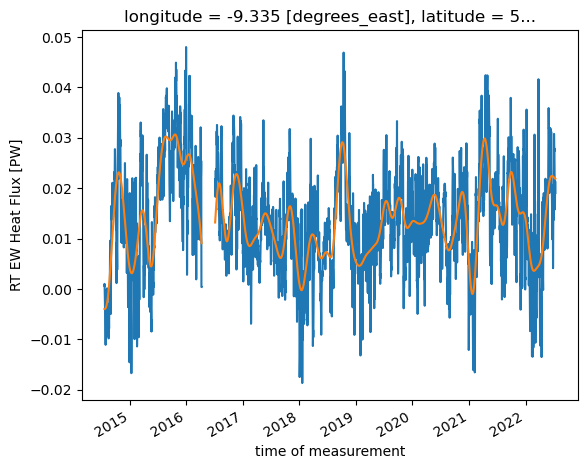

In [42]:
Qh_EW.where(Qh_EW.mask_EW).plot()
Qh_EW_lp.where(Qh_EW.mask_EW).plot()

### Get depth-accumulated transport

In [43]:
qz_EW = q_EW.sum('lon_EW')
qz_WW = q_WW.sum('lon_WW')
qz_MB = q_MB
qz_MB_grid = q_MB_grid.sum('lon_MB')
Q_MB_cumul = qz_MB.sel(depth=slice(None,P_ref))/1e6
Q_MB_grid_cumul = qz_MB_grid.sel(depth=slice(None,P_ref))/1e6
Q_EW_cumul = qz_EW.sel(depth=slice(None,P_ref))/1e6
Q_WW_cumul = qz_WW.sel(depth=slice(None,P_ref))/1e6

### Standard errors

In [44]:
# transport
SEw = rtf.std_error(Q_WW)
SEm = rtf.std_error(Q_MB)
SEm_grid = rtf.std_error(Q_MB_grid)
SEe = rtf.std_error(Q_EW)
SE = rtf.std_error((Q_WW.fillna(0) + Q_MB + Q_EW.fillna(0)))

# HF
SEhw = rtf.std_error(Qh_WW)
SEhm = rtf.std_error(Qh_MB)
SEhm_grid = rtf.std_error(Qh_MB_grid)
SEhe = rtf.std_error(Qh_EW)
SEh = rtf.std_error((Qh_WW.fillna(0) + Qh_MB + Qh_EW.fillna(0)))

# FF
SEfw = rtf.std_error(Qf_WW)
SEfm = rtf.std_error(Qf_MB)
SEfm_grid = rtf.std_error(Qf_MB_grid)
SEfe = rtf.std_error(Qf_EW)
SEf = rtf.std_error((Qf_WW.fillna(0) + Qf_MB + Qf_EW.fillna(0)))

'x has 5827 data cycles'

'Integral time scale (days) = 67.47983775778272'

' : Degrees of freedom = 86.35171917448703'

'x has 5827 data cycles'

'Integral time scale (days) = 137.8294606230701'

' : Degrees of freedom = 42.276883139921885'

'x has 5827 data cycles'

'Integral time scale (days) = 137.82895306656604'

' : Degrees of freedom = 42.27703882496869'

'x has 5827 data cycles'

'Integral time scale (days) = 68.51721584758108'

' : Degrees of freedom = 85.04431956141305'

'x has 5827 data cycles'

'Integral time scale (days) = 113.7189562024179'

' : Degrees of freedom = 51.24035776082955'

'x has 5827 data cycles'

'Integral time scale (days) = 59.91585129632259'

' : Degrees of freedom = 97.25306198491148'

'x has 5827 data cycles'

'Integral time scale (days) = 136.27378941019685'

' : Degrees of freedom = 42.759506616934125'

'x has 5827 data cycles'

'Integral time scale (days) = 136.16642420096852'

' : Degrees of freedom = 42.79322185474967'

'x has 5827 data cycles'

'Integral time scale (days) = 77.06284880528995'

' : Degrees of freedom = 75.61360746892097'

'x has 5827 data cycles'

'Integral time scale (days) = 102.23512489329846'

' : Degrees of freedom = 56.996066724441015'

'x has 5827 data cycles'

'Integral time scale (days) = 64.63020816061047'

' : Degrees of freedom = 90.1590783294324'

'x has 5827 data cycles'

'Integral time scale (days) = 395.3817644428812'

' : Degrees of freedom = 14.73765490477444'

'x has 5827 data cycles'

'Integral time scale (days) = 394.65489345023013'

' : Degrees of freedom = 14.764798553637704'

'x has 5827 data cycles'

'Integral time scale (days) = 139.98386479627527'

' : Degrees of freedom = 41.62622605455487'

'x has 5827 data cycles'

'Integral time scale (days) = 290.3452638265319'

' : Degrees of freedom = 20.069209751192524'

In [45]:
print('Total transport errors')
print(SE.values)
print(SEh.values)
print(SEf.values)

print('Midbasin non-grid')
print(SEm.values)
print(SEhm.values)
print(SEfm.values)


print('Midbasin .grid')
print(SEm_grid.values)
print(SEhm_grid.values)
print(SEfm_grid.values)

Total transport errors
0.47005453404958397
0.003351670270271221
0.0025176548324021388
Midbasin non-grid
0.4819980811616497
0.0033576618042726793
0.0027573938548915307
Midbasin non-grid
0.48199621541695625
0.0033674139368542974
0.0027655051889796988


# Total transports


### Add attributes to total transport timeseries

In [46]:
Q_total = Q_WW.fillna(0)+Q_EW.fillna(0)+Q_MB
Q_total_lp = Q_WW_lp.fillna(0) + Q_MB_lp + Q_EW_lp.fillna(0)

Qh_total = Qh_WW.fillna(0)+Qh_EW.fillna(0)+Qh_MB
Qh_total_lp = Qh_WW_lp.fillna(0) + Qh_MB_lp + Qh_EW_lp.fillna(0)

Qf_total = Qf_WW.fillna(0)+Qf_EW.fillna(0)+Qf_MB
Qf_total_lp = Qf_WW_lp.fillna(0) + Qf_MB_lp + Qf_EW_lp.fillna(0)


Q_total.coords['mask']=(Q_total.mask_EW+Q_total.mask_WW)
Q_total = Q_total.where(Q_total.mask).compute()
Q_total_lp = Q_total_lp.where(Q_total.mask).compute()

Qh_total = Qh_total.where(Q_total.mask).compute()
Qh_total_lp = Qh_total_lp.where(Q_total.mask).compute()

Qf_total = Qf_total.where(Q_total.mask).compute()
Qf_total_lp = Qf_total_lp.where(Q_total.mask).compute()

In [47]:
units = 'Sv'
name = 'Volume\n Transport'
Q_total.attrs = dict(long_name=name, units=units)
Q_total_lp.attrs = dict(long_name=name, units=units)

units = 'PW'
name = 'Heat\n Transport'
Qh_total.attrs = dict(long_name=name, units=units)
Qh_total_lp.attrs = dict(long_name=name, units=units)

units ='Sv'
name = 'Freshwater\n Transport'
Qf_total.attrs = dict(long_name=name, units=units)
Qf_total_lp.attrs = dict(long_name=name, units=units)

### Standard error pre 2017 - check regime shift

In [48]:
SE_pre_2017 = rtf.std_error(Q_total.sel(TIME=slice(None,'2017')))
SEh_pre_2017 = rtf.std_error(Qh_total.sel(TIME=slice(None,'2017')))
SEf_pre_2017 = rtf.std_error(Qf_total.sel(TIME=slice(None,'2017')))

SE_after_2017 = rtf.std_error(Q_total.sel(TIME=slice('2017',None)))
SEh_after_2017 = rtf.std_error(Qh_total.sel(TIME=slice('2017',None)))
SEf_after_2017 = rtf.std_error(Qf_total.sel(TIME=slice('2017',None)))

Q=Q_total.sel(TIME=slice(None,'2017'))
print(f"Q Pre 2017 mean is {Q.mean('TIME').values}, std dev is {Q.std('TIME').values}, std error is {SE_pre_2017.values}")
Q=Qh_total.sel(TIME=slice(None,'2017'))
print(f"Qh Pre 2017 mean is {Q.mean('TIME').values}, std dev is {Q.std('TIME').values}, std error is {SEh_pre_2017.values}")
Q=Qf_total.sel(TIME=slice(None,'2017'))
print(f"Qf Pre 2017 mean is {Q.mean('TIME').values}, std dev is {Q.std('TIME').values}, std error is {SEf_pre_2017.values}")


'x has 2519 data cycles'

'Integral time scale (days) = 64.68350969573464'

' : Degrees of freedom = 38.94346506318453'

'x has 2519 data cycles'

'Integral time scale (days) = 108.1725568535158'

' : Degrees of freedom = 23.28686751308983'

'x has 2519 data cycles'

'Integral time scale (days) = 268.53371736298743'

' : Degrees of freedom = 9.380572483547644'

'x has 4038 data cycles'

'Integral time scale (days) = 130.6086699490777'

' : Degrees of freedom = 30.916783714085398'

'x has 4038 data cycles'

'Integral time scale (days) = 123.66093341046005'

' : Degrees of freedom = 32.653804953880766'

'x has 4038 data cycles'

'Integral time scale (days) = 147.7472278865543'

' : Degrees of freedom = 27.330462017876393'

Q Pre 2017 mean is 4.587957869197682, std dev is 3.49655564671184, std error is 0.5603032593262596
Qh Pre 2017 mean is 0.05138437551516136, std dev is 0.02659566413294451, std error is 0.005511315884504268
Qf Pre 2017 mean is -0.02302383513472204, std dev is 0.013036575154550695, std error is 0.004256462787198835


In [49]:
Q=Q_total.sel(TIME=slice('2017',None))
print(f"Q after 2017 mean is {Q.mean('TIME').values}, std dev is {Q.std('TIME').values}, std error is {SE_pre_2017.values}")
Q=Qh_total.sel(TIME=slice('2017',None))
print(f"Qh after 2017 mean is {Q.mean('TIME').values}, std dev is {Q.std('TIME').values}, std error is {SEh_pre_2017.values}")
Q=Qf_total.sel(TIME=slice('2017',None))
print(f"Qf after 2017 mean is {Q.mean('TIME').values}, std dev is {Q.std('TIME').values}, std error is {SEf_pre_2017.values}")

Q after 2017 mean is 4.244038249123674, std dev is 3.3802016723912764, std error is 0.5603032593262596
Qh after 2017 mean is 0.044209663684981214, std dev is 0.02488452916057586, std error is 0.005511315884504268
Qf after 2017 mean is -0.017019392721532342, std dev is 0.009588934606927427, std error is 0.004256462787198835


### Check trends in time-series

In [50]:
dim = 'TIME'
fit, slope, intc, trend_significant = rtf.detrend_data(Q_total,dim)

'x has 5827 data cycles'

'Integral time scale (days) = 103.81571126442799'

' : Degrees of freedom = 56.128305908901446'

# Prepare data to save

In [51]:
SE.attrs = {'name':'SE_total',
            'long_name':'Standard error',
            'description':'Standard error of total volume flux Q_total, Rockall Trough',
             'units':'Sv'}
SEe.attrs = {'name':'SE_EW',
            'long_name':'Standard error',
            'description':'Standard error of volume flux Q_EW at eastern wedge of Rockall Trough',
             'units':'Sv'}
SEm.attrs = {'name':'SE_MB',
            'long_name':'Standard error',
            'description':'Standard error of mid basin volume flux Q_MB of Rockall Trough',
             'units':'Sv'}
SEw.attrs = {'name':'SE_WE',
            'long_name':'Standard error',
            'description':'Standard error of volume flux Q_WW at western wedge of Rockall Trough',
             'units':'Sv'}

SEh.attrs = {'name':'SEh_total',
            'long_name':'Standard error',
            'description':'Standard error of total heat flux Qh_total, Rockall Trough',
             'units':'PW'}
SEhe.attrs = {'name':'SEh_EW',
            'long_name':'Standard error',
            'description':'Standard error of heat flux Qh_EW at eastern wedge of Rockall Trough',
             'units':'PW'}
SEhm.attrs = {'name':'SEh_MB',
            'long_name':'Standard error',
            'description':'Standard error of mid basin heat flux Qh_MB of Rockall Trough',
             'units':'PW'}
SEhw.attrs = {'name':'SEh_WE',
            'long_name':'Standard error',
            'description':'Standard error of heat flux Qh_WW at western wedge of Rockall Trough',
             'units':'PW'}

SEf.attrs = {'name':'SEf_total',
            'long_name':'Standard error',
            'description':'Standard error of total freshwater flux Qf_total, Rockall Trough',
             'units':'Sv'}
SEfe.attrs = {'name':'SEf_EW',
            'long_name':'Standard error',
            'description':'Standard error of freshwater flux Qf_EW at eastern wedge of Rockall Trough',
             'units':'Sv'}
SEfm.attrs = {'name':'SEf_MB',
            'long_name':'Standard error',
            'description':'Standard error of mid basin freshwater flux Qf_MB of Rockall Trough',
             'units':'Sv'}
SEfw.attrs = {'name':'SEf_WE',
            'long_name':'Standard error',
            'description':'Standard error of freshwater flux Qf_WW at western wedge of Rockall Trough',
             'units':'Sv'}

In [52]:
RT_Q_Qh_Qf = xr.merge([Q_total.rename('Q_total'),Q_total_lp.rename('Q_total_lp'),SE.rename('SE_total'),
          Q_EW.rename('Q_EW'),Q_EW_lp.rename('Q_EW_lp'),SEe.rename('SE_EW'),
          Q_MB.rename('Q_MB'),Q_MB_lp.rename('Q_MB_lp'),SEm.rename('SE_MB'),
          Q_WW.rename('Q_WW'),Q_WW_lp.rename('Q_WW_lp'),SEw.rename('SE_WW'),
          Qh_total.rename('Qh_total'),Qh_total_lp.rename('Qh_total_lp'),SEh.rename('SEh_total'),
          Qh_EW.rename('Qh_EW'),Qh_EW_lp.rename('Qh_EW_lp'),SEhe.rename('SEh_EW'),
          Qh_MB.rename('Qh_MB'),Qh_MB_lp.rename('Qh_MB_lp'),SEhm.rename('SEh_MB'),
          Qh_WW.rename('Qh_WW'),Qh_WW_lp.rename('Qh_WW_lp'),SEhw.rename('SEh_WW'),
          Qf_total.rename('Qf_total'),Qf_total_lp.rename('Qf_total_lp'),SEf.rename('SEf_total'),
          Qf_EW.rename('Qf_EW'),Qf_EW_lp.rename('Qf_EW_lp'),SEfe.rename('SEf_EW'),
          Qf_MB.rename('Qf_MB'),Qf_MB_lp.rename('Qf_MB_lp'),SEfm.rename('SEf_MB'),
          Qf_WW.rename('Qf_WW'),Qf_WW_lp.rename('Qf_WW_lp'),SEfw.rename('SEf_WW'),
         ])
RT_q = xr.merge([q_EW.rename('q_EW').drop(['longitude','latitude','time']),q_MB.rename('q_MB'),q_WW.rename('q_WW')])

In [53]:
ds_q_RTMB = ds_RT_MB_grid.drop('PRES').rename({'TIME':'time'})
ds_q_RTMB = ds_q_RTMB.rename({'lon_MB':'lon','lat_MB':'lat','dx_MB':'dx'})
ds_q_RTMB.coords['dz']=dz
ds_q_RTMB

<xarray.Dataset>
Dimensions:  (depth: 101, time: 5827, lon: 99)
Coordinates:
  * depth    (depth) float32 0.0 20.0 40.0 60.0 ... 1.96e+03 1.98e+03 2e+03
  * time     (time) datetime64[ns] 2014-07-21T12:00:00 ... 2022-07-12T12:00:00
    lat      (lon) float64 57.47 57.46 57.46 57.46 ... 57.11 57.11 57.11 57.1
  * lon      (lon) float64 -12.49 -12.46 -12.43 -12.4 ... -9.638 -9.609 -9.579
    dx       (lon) float64 1.826e+03 1.826e+03 1.827e+03 ... 1.843e+03 1.843e+03
    PRES     (depth) float64 0.0 20.19 40.38 60.57 ... 1.988e+03 nan nan
    dz       (depth) float32 10.0 20.0 20.0 20.0 20.0 ... 20.0 20.0 20.0 10.0
Data variables:
    q        (depth, lon, time) float64 826.5 827.8 840.9 848.6 ... nan nan nan
    CT       (lon, time, depth) float64 10.22 10.22 10.22 10.22 ... nan nan nan
    SA       (lon, time, depth) float64 35.56 35.56 35.56 35.56 ... nan nan nan

In [54]:
ds_q_RTEW = xr.Dataset()
ds_q_RTEW['q']=(RT_q.reset_coords().q_EW.rename('q')).rename({'lon_EW':'lon'})
ds_q_RTEW.coords['lat']=RT_q.reset_coords().lat_EW.rename({'lon_EW':'lon'})
ds_q_RTEW.coords['dx']=dx_EW.rename({'lon_EW':'lon'})
ds_q_RTEW.coords['dz']=dz
mask = ds_q_RTEW.q.notnull()
ds_q_RTEW['CT'] = (ds_RT.TG_EAST*ds_q_RTEW.q.notnull()).where(mask)
ds_q_RTEW['SA'] = (ds_RT.SG_EAST*ds_q_RTEW.q.notnull()).where(mask)
ds_q_RTEW = ds_q_RTEW.drop('PRES').rename({'TIME':'time'})

In [129]:
ds_q_RTWW = xr.Dataset()
ds_q_RTWW['q']=(RT_q.reset_coords().q_WW.rename('q')).rename({'lon_WW':'lon'})
ds_q_RTWW.coords['lat']=RT_q.reset_coords().lat_WW.rename({'lon_WW':'lon'})
ds_q_RTWW.coords['dx']=dx_WW.rename({'lon_WW':'lon'})
ds_q_RTWW.coords['dz']=dz
mask = ds_q_RTWW.q.notnull()
ds_q_RTWW['CT'] = (ds_RT.TG_WEST*ds_q_RTWW.q.notnull()).where(mask)
ds_q_RTWW['SA'] = (ds_RT.SG_WEST*ds_q_RTWW.q.notnull()).where(mask)
ds_q_RTWW = ds_q_RTWW.drop('PRES').rename({'TIME':'time'})
ds_q_RTWW

<xarray.Dataset>
Dimensions:  (depth: 101, time: 5827, lon: 100)
Coordinates:
  * depth    (depth) float32 0.0 20.0 40.0 60.0 ... 1.96e+03 1.98e+03 2e+03
  * time     (time) datetime64[ns] 2014-07-21T12:00:00 ... 2022-07-12T12:00:00
  * lon      (lon) float64 -13.03 -13.03 -13.02 -13.02 ... -12.52 -12.51 -12.51
    lat      (lon) float64 ...
    dx       (lon) float64 158.3 316.6 316.6 316.6 ... 316.6 316.6 316.6 158.3
    dz       (depth) float32 10.0 20.0 20.0 20.0 20.0 ... 20.0 20.0 20.0 10.0
Data variables:
    q        (lon, depth, time) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    CT       (time, depth, lon) float64 10.22 10.22 10.22 10.22 ... nan nan nan
    SA       (time, depth, lon) float64 35.56 35.56 35.56 35.56 ... nan nan nan

In [130]:
RT_q['dx_EW']=dx_EW
RT_q['dx_WW']=dx_WW
# RT_q['dx_MB']=dx_MB
RT_q['dz']=ds_RT.dz
 
RT_q['SA_MB'] = (ds_RT.SG_WEST + ds_RT.SG_EAST)/2
RT_q['CT_MB'] = (ds_RT.TG_WEST + ds_RT.TG_EAST)/2

mask = RT_q.q_EW.notnull()
RT_q['CT_EW'] = (ds_RT.TG_EAST*RT_q.q_EW.notnull()).where(mask)
RT_q['SA_EW'] = (ds_RT.SG_EAST*RT_q.q_EW.notnull()).where(mask)

mask = RT_q.q_WW.notnull()
RT_q['CT_WW'] = (ds_RT.TG_WEST*RT_q.q_WW.notnull()).where(mask)
RT_q['SA_WW'] = (ds_RT.SG_WEST*RT_q.q_WW.notnull()).where(mask)

In [131]:
RT_Q_Qh_Qf.to_netcdf(f'{data_out_path}RT_Q_Qh_Qf_timeseries_2014_2022.nc')
RT_q.to_netcdf(f'{data_out_path}RT_q_timeseries_2014_2022.nc')
RT_Q_Ek.to_netcdf(f'{data_out_path}RT_Ekman_timeseries_2014_2022.nc')

PermissionError: [Errno 13] Permission denied: b'C:\\Users\\sa07kb\\Projects\\Rockall_Trough_Transports\\data\\processed\\RT_Q_Qh_Qf_timeseries_2014_2022.nc'

In [ ]:
ds_q_RTMB.to_netcdf(f'{data_out_path}q_RTMB_timeseries_2014_2022.nc')
ds_q_RTWW.to_netcdf(f'{data_out_path}q_RTWW_timeseries_2014_2022.nc')
ds_q_RTEW.to_netcdf(f'{data_out_path}q_RTW_timeseries_2014_2022.nc')

# Plot timeseries

In [ ]:
RT_Q_Qh_Qf = xr.open_dataset(f'{data_out_path}RT_Q_Qh_Qf_timeseries_2014_2022.nc')
RT_q = xr.open_dataset(f'{data_out_path}RT_q_timeseries_2014_2022.nc')
RT_Q_Ek = xr.open_dataset(f'{data_out_path}RT_Ekman_timeseries_2014_2022.nc')

In [ ]:
ds_q_RTMB = xr.open_dataset(f'{data_out_path}q_RTMB_timeseries_2014_2022.nc')
ds_q_RTWW = xr.open_dataset(f'{data_out_path}q_RTWW_timeseries_2014_2022.nc')
ds_q_RTEW = xr.open_dataset(f'{data_out_path}q_RTW_timeseries_2014_2022.nc')

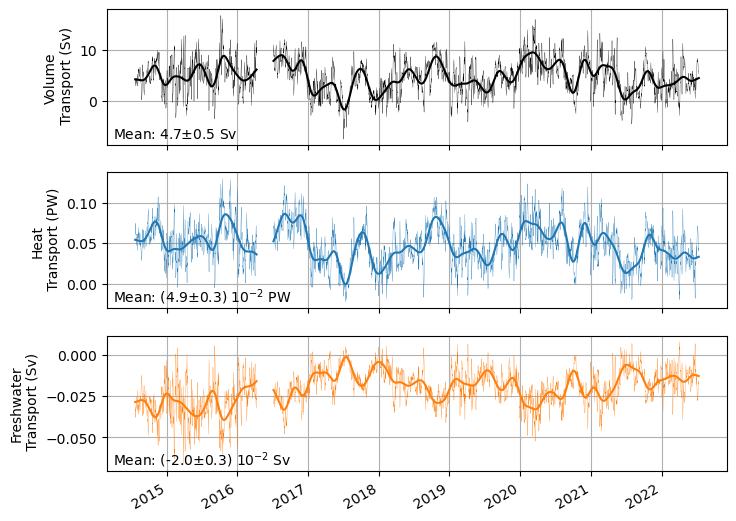

In [61]:
fig,axs = plt.subplots(3,1,sharex=True,figsize=[8,6])

ylabel_name = ['Volume\n Transport (Sv)','Heat\n Transport (PW)','Freshwater\n Transport (Sv)']
# build a rectangle in axes coords
left = .01
bottom = .05

# print(SE.values)
# print(SEh.values)
# print(SEf.values) Q_MB_grid

RT_Q_Qh_Qf.Q_total.where(RT_Q_Qh_Qf.mask_EW).plot.line('k',ax=axs[0],linewidth=.2)
RT_Q_Qh_Qf.Q_total_lp.where(RT_Q_Qh_Qf.mask_EW).plot.line('k',ax=axs[0],)
axs[0].text(left, bottom, ('Mean: %2.1f$\pm$%2.1f Sv' %(RT_Q_Qh_Qf.Q_total.mean().values,RT_Q_Qh_Qf.SE_total.values)),
        fontsize=10,
        transform=axs[0].transAxes)

RT_Q_Qh_Qf.Qh_total.where(RT_Q_Qh_Qf.mask_EW).plot.line('C0',ax=axs[1],linewidth=.2)
RT_Q_Qh_Qf.Qh_total_lp.where(RT_Q_Qh_Qf.mask_EW).plot.line('C0',ax=axs[1],)
axs[1].text(left, bottom, ('Mean: (%2.1f$\pm$%2.1f) 10$^{-2}$ PW' %(RT_Q_Qh_Qf.Qh_total.mean().values*1e2,RT_Q_Qh_Qf.SEh_total.values*1e2)),
        fontsize=10,
        transform=axs[1].transAxes)

RT_Q_Qh_Qf.Qf_total.where(RT_Q_Qh_Qf.mask_EW).plot.line('C1',ax=axs[2],linewidth=.2)
RT_Q_Qh_Qf.Qf_total_lp.where(RT_Q_Qh_Qf.mask_EW).plot.line('C1',ax=axs[2],)
axs[2].text(left, bottom, ('Mean: (%2.1f$\pm$%2.1f) 10$^{-2}$ Sv' %(RT_Q_Qh_Qf.Qf_total.mean().values*1e2,RT_Q_Qh_Qf.SEf_total.values*1e2)),
        fontsize=10,
        transform=axs[2].transAxes)

for i,ax in enumerate(axs):
    ax.grid()
    ax.set_title('')
    ax.set_ylabel(ylabel_name[i])
    ax.set_xlabel('')

# fig.savefig(r'C:\Users\sa07kb\Documents\Talks\20230423_28_EGU\Rockall_Trough_transports_2014_2022.png',dpi=300,bbox_inches='tight',)

In [133]:
ds_q_RT = xr.concat([ds_q_RTWW,ds_q_RTMB,ds_q_RTEW],'lon')


In [134]:
# ds_GEBCO.elevation.interp(lon=lon_WW, lat=lat_WW).drop(['lon','lat'])
ds_q_RT['bathy']=ds_GEBCO.elevation.interp(lon=ds_q_RT.lon, lat=ds_q_RT.lat)

In [135]:
def calc_SA_CT_sigma0(ds):
    
    sigma0_attrs = {'long_name':'Potential density referenced to 0dbar',
                   'description':'Potential density TEOS-10', 
                 'units':'kg/m^3'}
    
    ds['sigma0'] = xr.apply_ufunc(gsw.sigma0,
                  ds.SA,ds.CT,
                  dask = 'parallelized',output_dtypes=[float,])
    ds.sigma0.attrs = sigma0_attrs
    return ds

ds_q_RT = calc_SA_CT_sigma0(ds_q_RT)
ds_q_RT['v']=(ds_q_RT.q/(ds_q_RT.dx*ds_q_RT.dz))

C:\Users\sa07kb\AppData\Local\Continuum\miniconda3\envs\OSNAP_I\lib\site-packages\xarray\plot\dataarray_plot.py:1994: UserWarning: The following kwargs were not used by contour: 'kwargs'
  primitive = ax.contour(x, y, z, **kwargs)
C:\Users\sa07kb\AppData\Local\Continuum\miniconda3\envs\OSNAP_I\lib\site-packages\xarray\plot\dataarray_plot.py:1994: UserWarning: The following kwargs were not used by contour: 'kwargs'
  primitive = ax.contour(x, y, z, **kwargs)
C:\Users\sa07kb\AppData\Local\Continuum\miniconda3\envs\OSNAP_I\lib\site-packages\xarray\plot\dataarray_plot.py:1994: UserWarning: The following kwargs were not used by contour: 'kwargs'
  primitive = ax.contour(x, y, z, **kwargs)


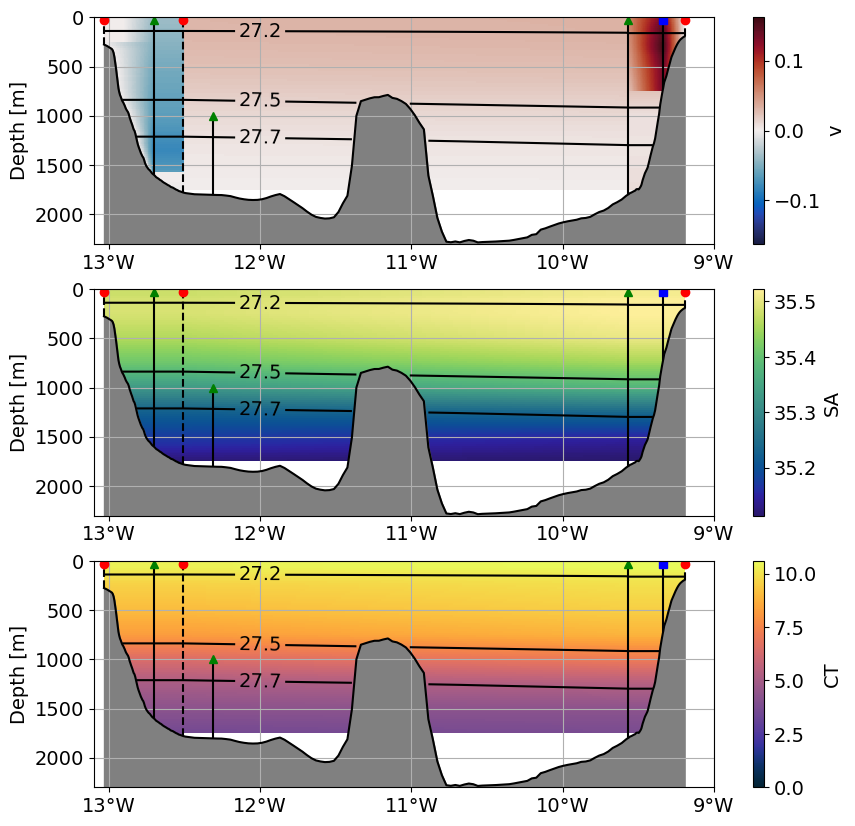

In [140]:
## figure
plt.rcParams.update({'font.size': 14})

xticks = np.arange(-13.,-8,1)
xticklabels = ['13°W','12°W','11°W','10°W','9°W']

sigma_contours = [27.2,27.5, 27.7]
manual_locations = [(-12,100),(-12,900),(-12,1250)]

# Set up figure
fig,axs = plt.subplots(3,1,figsize=[10,10])

ds_q_RT.v.mean('time',keep_attrs=True).plot(ax=axs[0],y='depth',x='lon',yincrease=False,cmap=cm.cm.balance)
ds_q_RT.SA.mean('time',keep_attrs=True).plot(ax=axs[1],y='depth',x='lon',yincrease=False,cmap=cm.cm.haline)
ds_q_RT.CT.mean('time',keep_attrs=True).plot(ax=axs[2],y='depth',x='lon',yincrease=False,cmap=cm.cm.thermal,vmin=0)

for ax in axs:
    ax.fill_between(ds_q_RT.lon, -ds_q_RT.bathy,2300,color='grey')
    (-ds_q_RT.bathy).plot.line('k',ax=ax)
    CS = ds_q_RT.sigma0.mean('time',keep_attrs=True).where(ds_q_RT.depth<=-ds_q_RT.bathy).plot.contour(
        ax=ax,x='lon',levels=sigma_contours,yincrease=False,colors='k',kwargs=dict(inline=True))
    ax.clabel(CS,manual=manual_locations)
    
    ax.vlines(lon_RTWB,-ds_q_RT.bathy.sel(lon=lon_RTWB,method='nearest'), 0,colors='k',ls='--')
    ax.vlines(lon_RTES,-ds_q_RT.bathy.sel(lon=lon_RTES,method='nearest'), 0,colors='k',ls='--')
    ax.vlines(lon_RTWS,-ds_q_RT.bathy.sel(lon=lon_RTWS,method='nearest'), 0,colors='k',ls='--')
    
    ax.vlines(lon_RTADCP,-ds_q_RT.bathy.sel(lon=lon_RTADCP,method='nearest'), 0,colors='k')
    ax.vlines(lon_RTEB,-ds_q_RT.bathy.sel(lon=lon_RTEB,method='nearest'), 50,colors='k')
    ax.vlines(lon_RTWB1,-ds_q_RT.bathy.sel(lon=lon_RTWB1,method='nearest'), 50,colors='k')
    ax.vlines(lon_RTWB2,-ds_q_RT.bathy.sel(lon=lon_RTWB2,method='nearest'), 1000,colors='k')
    
    d= 30.
    ax.plot([lon_RTES,lon_RTWS,lon_RTWB],[d,d,d],'or')
    ax.plot([lon_RTADCP],[d],'sb')
    ax.plot([lon_RTEB,lon_RTWB1],[d,d],'^g')
    ax.plot([lon_RTWB2],[1000],'^g')
    
    ax.set_xlim([-13.1,-9.])
    ax.set_xlabel('')
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels,fontsize=14)
    ax.grid()

    ax.set_ylabel('Depth [m]')
    ax.set_ylim([2300,0])